<a href="https://colab.research.google.com/github/jungyoojang/MachineLearning/blob/main/7_3_%EC%8B%A0%EA%B2%BD%EB%A7%9D_%EB%AA%A8%EB%8D%B8_%ED%9B%88%EB%A0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 신경망 모델 훈련

In [ ]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다.
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

## 손실 곡선

이전 절에서 fit()메서드로 모델을 훈련시키면 마지막에 아래 메시지가 출력됨

<keras.src.callbacks.History at 0x791e485923b0>

노트북의 코드 셀은 print()명령이 없어도 마지막 라인의 실행 결과를 자동으로 출력함

즉 위 메시지는 fit()메서드의 실행 결과를 출력한 것이며 다시 말해 fit()메서드가 무언가 반환한다는 것을 알려줌

History 클래스의 객체를 반환

In [ ]:
from tensorflow import keras # 데이터 준비
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()

train_scaled = train_input / 255.0 # 표준화

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

4422102/4422102 [==============================] - 1s 0us/step


In [ ]:
# 모델을 함수로 정의
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(100, activation='relu'))
    if a_layer: # 은닉층 뒤에 원하는 층을 더 추가할 수 있게 설정
        model.add(a_layer)
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [ ]:
model = model_fn()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모델 훈련
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
# 결과를 history에 저장
history = model.fit(train_scaled, train_target, epochs=5, verbose=0)

- verbose: 훈련 과정을 얼마나 자세히 출력할 것인가를 조절 (기본값=1)

epoch마다 진행 막대와 함께 손실등의 지표가 출력

0으로 설정하면 훈련 과정은 나타나지 않음

In [ ]:
print(history.history.keys()) # 손실, 정확도

dict_keys(['loss', 'accuracy'])


history객체에는 훈련 측정값이 담겨있는 history 딕셔너리가 들어 있음

손실과 정확도가 포함되어 있는데, 케라스는 기본적으로 에포크마다 손실을 계산함

정확도는 compile()메서드에서 metrics 매개변수에 'accuracy'를 추가했기 때문에 포함됨

손실과 정확도는 에포크마다 계산한 값이 순서대로 나열된 단순한 리스트이므로 맷플롯립을 사용해 그래프를 그릴 수 있음

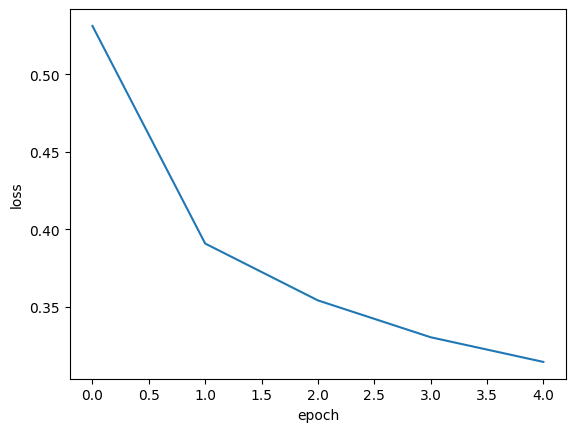

In [ ]:
# 측정값을 그래프로 그리기
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

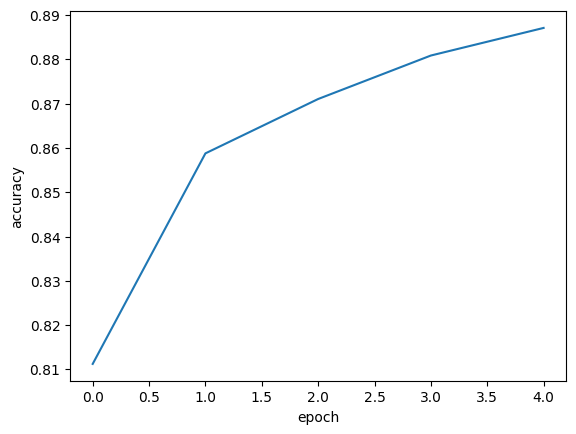

In [ ]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

에포크 늘어날수록 loss 감소하고 accuracy 늘어나는 걸 확인

**에포크 늘리기**

에포크를 더 늘릴수록 손실이 더더욱 감소함

In [ ]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0)

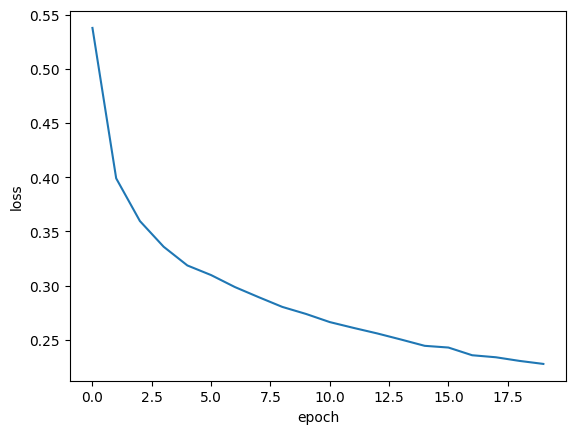

In [ ]:
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

손실이 더 낮아짐

이전보다 더 낮은 모델을 훈련한 것인가?

인공 신경망은 모두 일종의 경사 하강법을 사용하기 때문에 과대/과소적합과 에포크 사이의 관계를 조절해야함

에포크에 따른 과대/과소적합을 파악하려면 훈련 세트에 대한 점수 뿐만아니라 검증 세트에 대한 점수도 필요

이를 위해 필요한 것이 **검증 손실**

인공 신경망 모델이 최적화하는 대상은 정확도가 아니라 손실 함수

가끔씩 손실 감소에 비례하여 정확도가 높아지지 않는 경우도 있지만 손실 함수를 기준으로 최적화를 수행함

왜 손실 함수를 지표로 삼는가?

예를 들어 100개의 훈련 데이터 중 30개만 올바르게 예측하면 정확도는 30%

이때 가중치 매개변수를 약간 조정한다고 해도 정확도는 그대로 30%로서 약간의 매개변수 조정은 정확도에 의미있는 변화를 주기 힘듬

왜냐하면 30.00003%와 같은 연속적인 값보다는 32%,33%처럼 불연속적인 값으로 표현되기 때문에 정확도에 의미있는 변화를 주기 위해 가중치 매개변수의 변화 폭이 크거나 훈련 데이터가 많아야 함

반면에 손실함수는 불연속적인 값으로 표현되어 약간의 매개변수 변화로도 값에 변화를 줄 수 있음

## 검증 손실

신경망 학습에서는 최적의 매개변수를 찾는 방법

기울기를 계산하고 이를 기반으로 매개변수의 값을 조금씩 조정하는 과정의 반복

만약 기울기가 0이 되면 현 매개변수가 최적값으로 설정

또는 반복횟수에 제한이 있다면 그 제한안에서 최소의 기울기를 가지는 매개변수를 최적값으로 설정

검증 세트에 대한 손실과 정확도 점수를 구해보자

In [ ]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target)) # 검증세트 결과도 반환

In [ ]:
print(history.history.keys()) # key가 추가로 더 생김

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


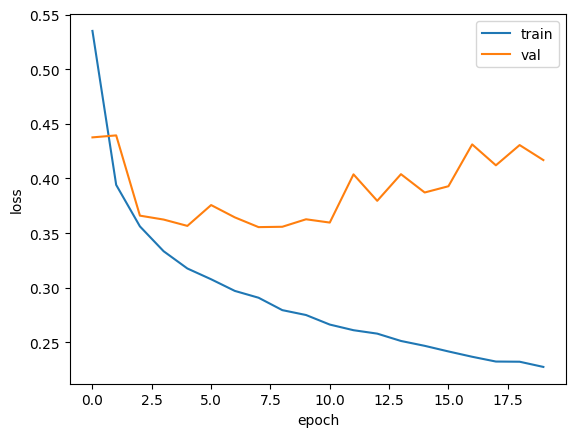

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) # 검증세트의 loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

검증 손실은 감소하다가 점점 상승함

훈련 손실은 꾸준히 감소하기 때문에 전형적인 **과대적합** 모델이 만들어짐

검증 손실이 상승하는 시점을 가능한 뒤로 늦추면 검증 세트에 대한 손실이 줄어들 뿐만 아니라 검증 세트에 대한 정확도도 증가할 것

우선 **옵티마이저 하이퍼파라미터를 조정**하여 과대적합을 완화시켜보자

기본 RMSprop 옵티마이저는 많은 문제에서 잘 동작함

다른 옵티마이저는 Adam이 좋음

Adam은 적응적 학습률을 사용하기 떄문에 에포크가 진행되면서 학습률의 크기를 조정할 수 있음

In [ ]:
model = model_fn()
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
adam_lr = keras.optimizers.Adam(learning_rate=0.01) # adam 적용
model.compile(optimizer='adam_lr', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

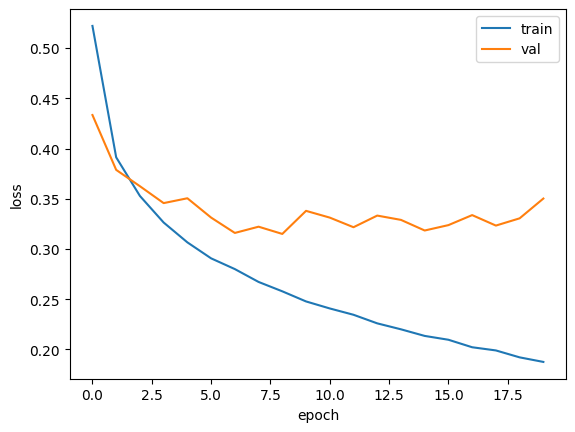

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

과대적합이 감소됨

검증 손실 그래프에 여전히 요동이 있지만 16번째 에포크부터는 전반적인 감소 추세가 이어지고 있음

이것은 Adam 옵티마이저가 이 데이터세트에 잘 맞는다는 것을 보여줌

더 나은 손실 곡선을 얻으려면 학습률을 조정해서 시도할 수 있음

## 드롭아웃 (dropout)

신경망에서 사용하는 대표적인 **규제** 방법

훈련 과정에서 층에 있는 일부 뉴런을 랜덤하게 꺼서 (즉 해당 뉴런의 출력을 0으로 만들어) 과대 적합을 막음

반면에 드롭아웃을 하지 않은 뉴런의 출력은 1/(1-r)만큼 증가시켜 출력의 총합이 같도록 함

여기서 r은 드롭할 뉴런의 비율로서 하이퍼파라미터

반면에 검증이나 평가할 때는 모든 뉴런을 사용함

예를 들어,

어떤 샘플을 처리할 때는 은닉층의 n2 번째 뉴런이 드롭아웃되어 h2 출력이 없음

다른 샘플을 처리할 때는 은닉층의 n1 번째 뉴런이 드롭아웃되어 h1 출력이 없음

- Dropout() : 드롭아웃 기능을 제공하는 클래스. 얼마나 drop할지 비율을 지정해야 함.

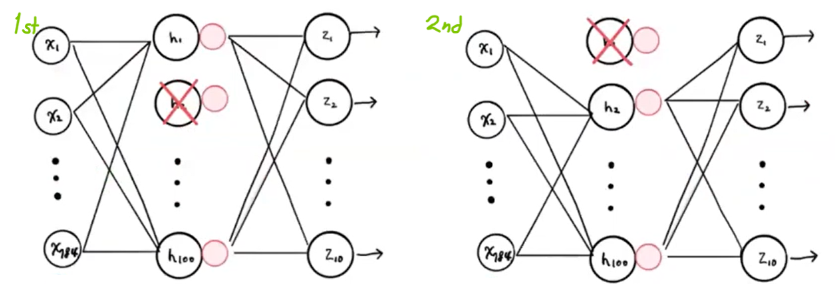

**드롭아웃이 과대적합을 막을수 있는 이유(해석)**

1. 이전 층의 일부 뉴런이 랜덤하게 꺼지면 특정 뉴런에 과대하게 의존하는 것을 줄일 수 있고 모든 입력에 대해 주의를 기울여야 함. 즉, 일부 뉴런의 출력이 없을수도 있다는 것을 감안하면 신경망은 더 안정적인 예측을 만들 수 있을 것임

2. 드롭아웃을 적용해 훈련하는 것은 마치 2개의 신경망을 앙상블하는 것처럼 적용 될 수 있음

In [ ]:
model = model_fn(keras.layers.Dropout(0.3)) # 드롭아웃을 30% 정도 수행

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


은닉층 뒤에 추가된 드롭아웃 층은 훈련되는 모델 파라미터가 없고 입력과 출력의 크기가 같음

단지 일부 뉴런의 출력을 0으로 만듦

훈련이 끝난 뒤에 평가나 예측을 수행할 때는 드롭아웃을 적용하지 않아야 함

텐서플로와 케라스는 모델을 평가와 예측에 사용될 때는 자동으로 드롭아웃을 적용하지 않음

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

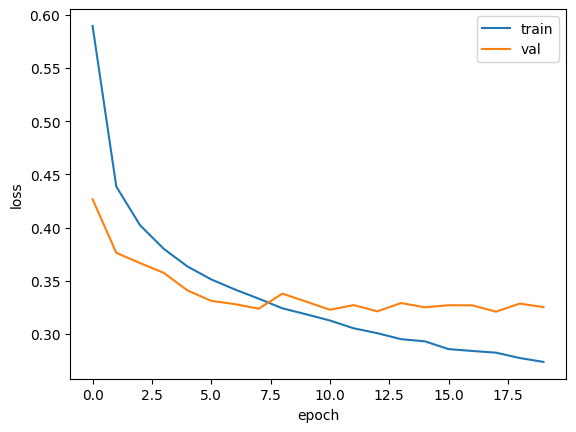

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

import numpy as np
min_loss = np.argmin(history.histroy['val_loss'])
print(min_loss)

과대적합이 많이 줄음

15번째 에포크에서 검증 손실의 감소가 멈추지만 크게 상승하지 않고 어느 정도 유지하고 있음

이 모델은 20번의 에포크동안 훈련을 했기 때문에 결국 다소 과대적합이 되어 있음

과대적합이 되지 않은 모델을 얻기 위해 **최적의 에포크 횟수를 설정**으로 하고 다시 훈련하자

## 모델 저장과 복원

만들어진 모델을 나중에 다시 사용하려면 모델을 저장해야 함

케라스 모델은 훈련된 모델의 파라미터를 저장하는 **save_weights()** 메서드를 제공함

이 메서드는 텐서플로의 체크포인트 포멧으로 저장하지만 확장자가 '.h5'일 경우 HDF5 포멧으로 저장

또한 모델 구조와 모델 파라미터를 함께 저장하는 **save()** 메서드도 제공함

이 메서드는 텐서플로의 SavedModel 포멧으로 저장하지만 확장자가 '.h5'일 경우 HDF5 포멧으로 저장

In [ ]:
model = model_fn(keras.layers.Dropout(0.3)) # 최적의 epoch로 다시 저장한 모델
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=10, verbose=0,
                    validation_data=(val_scaled, val_target))

In [ ]:
model.save_weights('model-weights.h5')

In [ ]:
model.save('model-whole.h5')

두 파일이 제대로 만들어 졌는지 확인

'!'문자로 시작되면 코랩은 이후 명령을 파이썬 코드가 아리나 리눅스 쉘 명령으로 인식

In [ ]:
# a : 경로안의 모든 파일과 디렉토리 표시
# -l : 지정한 디렉토리 내용을 자세히 표시
!ls -al *.h5

-rw-r--r-- 1 root root 333320 Jul 14 08:12 model-weights.h5
-rw-r--r-- 1 root root 981176 Jul 14 08:12 model-whole.h5


**load_weights()**은 이전에 저장했던 모델의 가중치를 복원하는(불러오는) 메소드

모델 파라미터만 보관하고 있으므로 저장했던 모델과 정확히 같은 구조를 가져야 함

In [ ]:
model = model_fn(keras.layers.Dropout(0.3)) # 새 모델 만들고

model.load_weights('model-weights.h5') # 만들었던 가중치 반영

**모델의 검증 정확도 확인 - 1**
- predict(): 샘플마다 모든(여기서는 10개) 클래스에 대한 확률을 반환

모든 클래스별 확률을 주기 때문에 10개의 확률 중 가장 큰 값의 인덱스를 골라 타깃 레이블과 비교하여 정확도를 계산해야 함

In [ ]:
import numpy as np

val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target)) # 일치 비율이 곧 검증세트의 정확도

375/375 [==============================] - 1s 1ms/step
0.8775


- arg_max(): predict가 출력한 확률들 중에 가장 큰 값을 뽑기 위해 넘파이 활용

axis=1: 배열의 마지막 차원을 따라 최대값의 인덱스 선택

2차원이므로 마지막 차원은 1이 되며, 열을 따라 각 행의 최대값의 인덱스 선택

axis=0: 행을따라 각 열의 최대값의 인덱스를 선택

기본값은 None으로 전체 배열에서 최대값을 찾음

**모델의 검증 정확도 확인 - 2**

- evaluate()

손실을 출력하기 위해 complie()메서드를 먼저 실행해야 함

fit()메서드는 실행할 필요없음. 이미 훈련한 모델의 파라미터를 불러와서 사용하기 때문

- load_model() : 이전에 저장했던 모델 전체를 불러오는 메소드



In [ ]:
model = keras.models.load_model('model-whole.h5')

model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.3388 - accuracy: 0.8775


[0.3387581408023834, 0.8774999976158142]

**모델 전체를 파일에서 읽고 모델의 검증 정확도 확인**

keras.models.load_model() 함수는 모델 파라미터 뿐만 아니라 모델 구조와 옵티마이저 상태까지 모두 복원하기 때문에 compile()없이 evaluate() 사용 가능

## 콜백

위 과정은 20번의 에포크 동안 모델을 훈련하여 검증 점수가 상승하는 지점을 확인한 후 과대적합 되지 않는 에포크로 다시 훈련했음

모델을 두 번 씩 훈련하지 않고 한 번에 끝낼 수 있는 방법은 **콜백**을 이용하는 것임

콜백은 훈련 과정 중간에 특정 작업을 수행할 수 있게 하는 객체로서 keras.callbacks 패키지 아래에 있는 클래스

fit() 메서드의 callbacks 매개변수에 **리스트**로 전달하여 사용

**ModelCheckPoint 콜백**

에포크마다 모델을 저장

- save_best_only: 손실이 가장 낮은 모델만 저장

- monitor: 모니터링할 지표를 지정 기본값은 val_loss로 검증 손실을 관찰함

- save_weights_only: 기본값은 False로 전체 모델을 저장함. True로 지정하면 모델의 가중치와 절편만 저장함

In [ ]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', # 콜백
                                                save_best_only=True)

model.fit(train_scaled, train_target, epochs=20, verbose=0,
          validation_data=(val_scaled, val_target),
          callbacks=[checkpoint_cb]) # 콜백 매개변수에 넣어줌

In [ ]:
model = keras.models.load_model('best-model.h5') # 콜백해둔 best_model 가져옴

model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.3201 - accuracy: 0.8841


[0.3201218545436859, 0.8840833306312561]

**EarlyStopping 콜백**

위 모델은 가장 낮은 검증 점수를 가지는 모델을 자동으로 저장해주나 여전히 20번의 에포크동안 훈련을 해야함

검증 점수가 상승하기 시작하면 그 이후에는 과대적합이 더 커지기 때문에 훈련을 계속할 필요가 없으므로 이때 훈련을 중지하면 컴퓨터 자원과 시간을 아낄 수 있음

과대적합이 시작되기 전에 훈련을 미리 중지하는 것을 **조기 종료**라고 하며 딥러닝에서 널리 사용함

조기 종료는 훈련 에포크 횟수를 제한하는 역할이지만 모델이 과대적합되는 것을 막아주기 때문에 규제 방법 중 하나로 생각할 수도 있음

- patience: 검증 점수가 향상되지 않더라도 참을 에포크 횟수를 지정할 수 있음

- restore_best_weights: True로 지정하면 가장 낮은 검증 손실을 낸 모델 파라미터로 되돌림

- monitor: 모니터링할 지표를 지정함. 기본값은 val_loss로 검증 손실을 관찰함

EarlyStopping 콜백을 ModelCheckpoint 콜백과 함께 사용하면 가장 낮은 검증 손실의 모델을 파일에 저장하고 검증 손실이 다시 상승할 떄 훈련을 중지할 수 있음

또한 훈련을 중지한 다음 현재 모델의 파라미터를 최상의 파라미터로 되돌림

In [ ]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', # 체크포인트
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, # 조기종료
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb]) # 추가

In [ ]:
print(early_stopping_cb.stopped_epoch) # 조기종료한 에포크 출력

7


7번째 에포크에서 훈련이 중지됨. patience를 2로 지정했으므로 최상의 모델은 5번째 에포크 일것임.

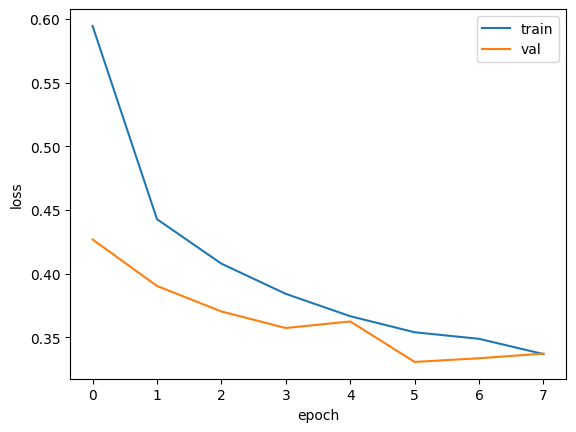

In [ ]:
# 그림으로 확인
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

최상의 에포크가 5인것을 확인

**최종 모델**

In [ ]:
model.evaluate(val_scaled, val_target) # 검증세트 성능 최종 확인

375/375 [==============================] - 1s 2ms/step - loss: 0.3307 - accuracy: 0.8768


[0.33070704340934753, 0.8768333196640015]

# 정리

fit의 반환값을 사용해서 훈련세트 & 검증세트의 손실을 그래프로 그려봄

-> 과대적합 발견

-> 신경망의 대표적인 규제방법인 드롭아웃으로 완화

-> 만든 모델(가중치 or 모델 전체)을 저장하고 복원하는 기능

-> 콜백 기능을 사용하니 그 과정을 자동화해서 편리하게 최상의 모델을 만들 수 있게 됨 = ModelCheckpoint로 최상의 모델만 저장하고, EarlyStopping으로 불필요하게 훈련 길어지는 것도 막음